First part: just checking access to the radar data.

In [1]:
%%bash
cat > radar.datacube << EOF
[default]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: radar
EOF

In [10]:
import datacube
sarcube = dc = datacube.Datacube(config='radar.datacube')
z = dc.find_datasets(product='s1_gamma0_scene') # group by solar day?
len(z)

2433

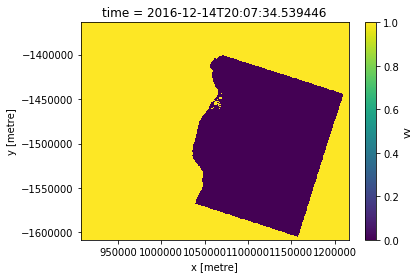

In [5]:
example_radar = dc.load(product='s1_gamma0_scene', datasets=z[:1], output_crs='epsg:3577', resolution=(25,-25))
(example_radar.isel(time=0).vv.loc[::20,::20] == 0).plot()

Second part: determining whether there is matching wofs data.

Note, probably I should just find the nearest observation, then check whether it is within 18hrs or some such. (Or do the fancy bracketing thing.) Matching dates is just an interim shortcut. And probably not a great one, e.g., nearest radar observation is probably the night before.

In fact, maybe I should manually create a time window, and try to fuse more agressively than solar day?

In [24]:
import pytz
def localdate(ds):
    return str(ds.time.begin.replace(tzinfo=pytz.timezone('UTC')).astimezone(pytz.timezone('Australia/Sydney')))[:10]
[localdate(x) for x in z][:5]

['2016-12-15', '2016-12-10', '2016-12-22', '2016-12-03', '2017-04-03']

In [25]:
prod = datacube.Datacube()

In [32]:
attempts = 150
y = [prod.find_datasets(product="wofs_albers", 
                        geopolygon=scene.extent, 
                        time=localdate(scene)) 
     for scene in z[:attempts]]
str([len(i) for i in y])

'[18, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 10, 0, 0, 0, 12, 0, 5, 0, 16, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 16, 0, 0, 0, 0, 0, 15, 0, 0, 0, 1, 0, 1, 16, 19, 0, 0, 12, 0, 10, 18, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 10, 10, 12, 12, 4, 0, 0, 18, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 17, 18, 18, 0, 0, 0, 0, 6, 0, 0, 12, 0, 13, 0, 2, 0, 15, 22, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 17, 0, 0, 0]'

In [37]:
max([len(set(map(localdate, i))) for i in y]) # was the query using local or utc dates?

1

In [259]:
import digitalearthau.utils

for scene, tiles in zip(z, y):
    if tiles:
        radar = dc.load(product='s1_gamma0_scene', datasets=[scene], 
                        output_crs='epsg:3577', resolution=(25,-25))
        wofs = prod.load(product='wofs_albers', datasets=tiles, like=radar,
                        group_by='solar_day', fuse_func=digitalearthau.utils.wofs_fuser)
        assert len(radar.time) == 1
        assert len(wofs.time) == 1
        radar = radar.isel(time=0)
        wofs = wofs.isel(time=0)
        
        wet = wofs.water == 128
        dry = wofs.water == 0
        clear = wet | dry
        
        validradar = (radar.vv != 0) & (radar.vh != 0)
        
        overlap = clear & validradar
        
        overlap_flag = overlap.data.any()
        if overlap_flag:
            wetoverlap = wet & overlap
            print(overlap.data.sum(),"\t", wetoverlap.data.sum())
        else:
            print('-')
        
        #break

6381309 	 909
-
-
6655016 	 10292
5878235 	 147963
-
22619017 	 126443
-
-
32289550 	 143938
13950636 	 820614
25176021 	 135138
-
-
10733523 	 7463
13671370 	 107
11736199 	 16389
11311565 	 4391
2956511 	 34291
5176085 	 119284
-
24488920 	 80490
6292472 	 2861
15917940 	 1093619
-
-
31853908 	 100599
-
14367197 	 17898
11402633 	 192054
36995694 	 289825
-
13146862 	 2678
13680286 	 41
-
18227280 	 1346604
6903633 	 65134
13211044 	 4327
22236192 	 78001
-
-
25399 	 2581
-
33834520 	 3082


In [ ]:
class pairing

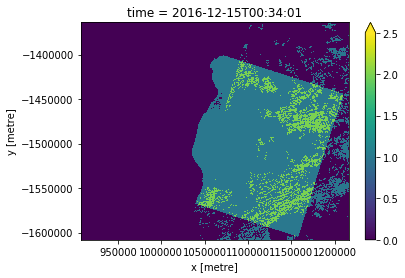

In [107]:
s = 10
((radar.vv[::s,::s]!=0) + 0 + clear[::s,::s] + wetoverlap[::s,::s]).plot(vmax=2.5)

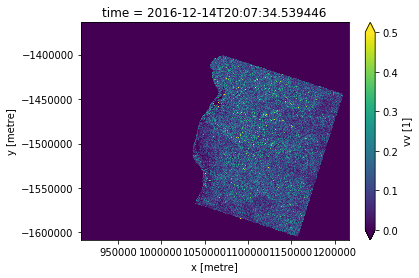

In [115]:
radar.vv[::20,::20].plot(vmax=0.5,vmin=0)

In [102]:
import numpy as np
import matplotlib.pyplot as plt

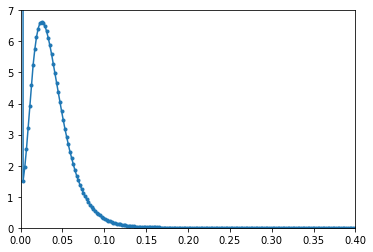

In [162]:
def hist1d(pol):
    x = pol.values.copy().ravel()
    counts, edges = np.histogram(x, bins=500, range=(0,1))
    widths = edges[1:] - edges[:-1]
    centres = (edges[1:] + edges[:-1]) / 2
    plt.plot(centres, counts / widths / counts.sum(), marker='.')
    plt.ylim(0,7)
    plt.xlim(0,0.4)
hist1d(radar.vh)

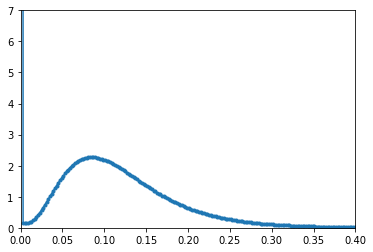

In [163]:
hist1d(radar.vv)

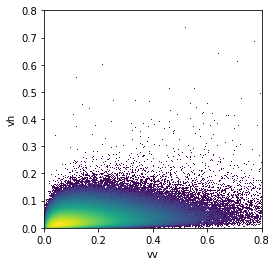

In [261]:
def hist2d(radar): 
    s = 0.8
    vh = radar.vh.values.copy().ravel()
    vv = radar.vv.values.copy().ravel()
    counts, *edges = np.histogram2d(vh, vv, bins=500, range=[[0,s],[0,s]])
    counts[counts==0] = np.nan # mask zero counts
    counts[0,0] = np.nan # exclude nodata
    plt.imshow(np.log10(counts), origin='lower', extent=(0,s,0,s))
    plt.xlabel('vv')
    plt.ylabel('vh')
    return counts
x = hist2d(radar)

Great, this is the plot I'm after, just need to separate wet and dry.

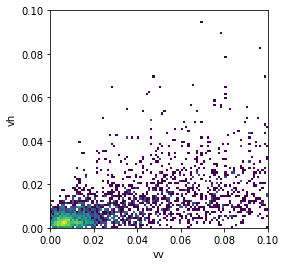

In [260]:
def parthist(radar, subset): 
    s = 0.1
    vh = radar.vh.values.copy().ravel()[subset.values.ravel()]
    vv = radar.vv.values.copy().ravel()[subset.values.ravel()]
    counts, *edges = np.histogram2d(vh, vv, bins=100, range=[[0,s],[0,s]])
    counts[counts==0] = np.nan # mask zero counts
    counts[0,0] = np.nan # exclude nodata
    plt.imshow(np.log10(counts), origin='lower', extent=(0,s,0,s))
    plt.xlabel('vv')
    plt.ylabel('vh')
    return counts
x = parthist(radar, wetoverlap)

In [262]:
wetoverlap.values.sum()

3082

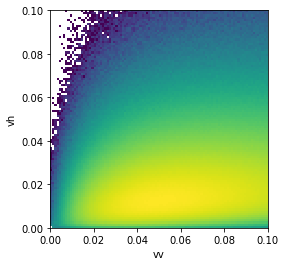

In [264]:
x = parthist(radar, overlap & ~wet)

But this is all getting cumbersome. New idea:

Let there be a class. It represents a match. It is created from the radar dataset record. It finds its own wofs records, loads the data, probably caches the overlap data. It can self-check in case there will be no useful data. It has methods for plotting. It can also cache histogram counts.

It may overload some operation for amalgamating results from separate observations.

There might be a classmethod for generating a series of these things (while filtering out those which fail self checks).

In [1]:
import functools

class comparison:
    def __init__(self, radar_dataset):
        self.ds = radar_dataset
        self.date = localdate(self.ds)
    @property
    @functools.lru_cache(maxsize=None)
    def wofs_datasets(self):
        """Search index forr wofs scenes that potentially overlap the radar"""
        return prod.find_datasets(product="wofs_albers", geopolygon=self.ds.extent, time=self.date)
    def load(self):
        """Load full raster data (using cached index records)"""
        radar = dc.load(product='s1_gamma0_scene', datasets=[self.ds], 
                        output_crs='epsg:3577', resolution=(25,-25))
        assert len(radar.time) == 1
        wofs = prod.load(product='wofs_albers', datasets=self.wofs_datasets, like=radar,
                         group_by='solar_day', fuse_func=digitalearthau.utils.wofs_fuser)
        assert len(wofs.time) == 1
        return radar.isel(time=0), wofs.isel(time=0)
    def overlay(self):
        """Extract and categorise comparable pixels"""
        radar, wofs = self.load()
        
        wet = wofs.water == 128
        dry = wofs.water == 0
        clear = wet | dry
        
        validradar = (radar.vv > 0) & (radar.vh > 0)
        
        overlap = clear & validradar
        self.overlap = overlap.data.sum()
             
        if self.overlap:
            def extract(subset):
                vv = radar.vv.values.ravel()[subset.values.ravel()]
                vh = radar.vh.values.ravel()[subset.values.ravel()]
                return vv, vh
            self.wet_vv, self.wet_vh = extract(wet & overlap)
            self.dry_vv, self.dry_vh = extract(dry & overlap)
        return self.overlap

    def check(self):
        """True if contains useable overlap. Induces data load."""
        if self.wofs_datasets > 0:
            if self.overlay > 0:
                return True
        return None        
    def histograms(self):
        pass
    
    
            radar = dc.load(product='s1_gamma0_scene', datasets=[scene], 
                        output_crs='epsg:3577', resolution=(25,-25))
        wofs = prod.load(product='wofs_albers', datasets=tiles, like=radar,
                        group_by='solar_day', fuse_func=digitalearthau.utils.wofs_fuser)
        assert len(radar.time) == 1
        assert len(wofs.time) == 1
        radar = radar.isel(time=0)
        wofs = wofs.isel(time=0)
        
        wet = wofs.water == 128
        dry = wofs.water == 0
        clear = wet | dry
        
        validradar = (radar.vv != 0) & (radar.vh != 0)
        
        overlap = clear & validradar
        
        overlap_flag = overlap.data.any()
        if overlap_flag:
            wetoverlap = wet & overlap
            print(overlap.data.sum(),"\t", wetoverlap.data.sum())
        else:
            print('-')

In [9]:
class dummy:
    def __init__(self, x):
        self.x = x
    def A(self):
        raise NotImplementedError

In [10]:
x = [dummy(i) for i in [1,2,3]]

In [7]:
class dummy:
    def __init__(self, x):
        self.x = x
    def A(self):
        self.x += 1
    def B(self):
        return self.x

In [13]:
dummy.B = lambda self: self.x
def f(self):
    self.x += 1
dummy.A = f

In [14]:
[i.B() for i in x]

[1, 2, 3]

In [15]:
[i.A() for i in x]

[None, None, None]

In [16]:
[i.B() for i in x]

[2, 3, 4]

In [17]:
def dummy.C(self):
    pass

SyntaxError: invalid syntax (<ipython-input-17-32060c3c7510>, line 1)

In [18]:
import numpy as np

In [23]:
np.concatenate([[1,2,3],[4,5,6]])

array([1, 2, 3, 4, 5, 6])